# Problem Set 1 (MACS 30250)
## Submitted by- Nipun Thakurele

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
import timeit
import random
import multiprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from dask import compute, delayed
import dask.multiprocessing
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [2]:
url = ('https://raw.githubusercontent.com/UC-MACSS/persp-research-econ_Spr19/' +
       'master/Assignments/PS1/data/BQmat_orig.txt')
bq_data = np.loadtxt(url, delimiter=',')

## Question 1(a)

In [3]:
age_vec = np.arange(18, 96)
prcntl = np.array([0.25, 0.25, 0.20, 0.10, 0.10, 0.09, 0.01])
prcntl_midpts = np.array([0.125, 0.375, 0.60, 0.75, 0.85,
                          0.94, 0.995])

income_mat, age_mat = np.meshgrid(prcntl_midpts, age_vec)

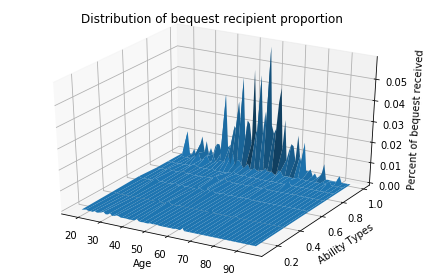

In [4]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(age_mat, income_mat, bq_data)
ax.set_title('Distribution of bequest recipient proportion')
ax.set_xlabel('Age')
ax.set_ylabel('Ability Types')
ax.set_zlabel('Percent of bequest received')
plt.tight_layout()

## Question 1(b)

In [5]:
df = pd.DataFrame(bq_data)
flat_df = pd.DataFrame()
df.columns = prcntl_midpts
df.index = age_vec
for r in df.index:
    for c in df.columns:
        flat_df = flat_df.append([[r, c, df.loc[r][c]]])

In [6]:
gen_df = pd.DataFrame()
flat_df.index = np.arange(0, 546)
flat_df.columns = ['age', 'percentile', 'p']
ind = np.random.choice(546, 1000, p = flat_df['p'])
gen_df = flat_df.iloc[ind][['age', 'percentile']]

In [8]:
bandwidth = 0.25
kernel = gaussian_kde(gen_df.T, bw_method=bandwidth)

age_min = gen_df['age'].min()
age_max = gen_df['age'].max()
per_min = gen_df['percentile'].min()
per_max = gen_df['percentile'].max()

age_i, per_i = np.mgrid[age_min:age_max:78j,
                              per_min:per_max:100j]

coords = np.vstack([item.ravel() for item in [age_i, per_i]])
Z = np.reshape(kernel(coords), age_i.shape)
Z_scaled = Z / float(np.sum(Z))

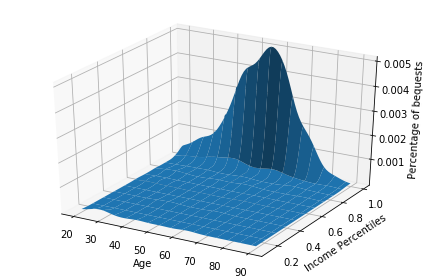

In [9]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(age_i, per_i, Z_scaled, rstride=5)
ax.set_xlabel("Age")
ax.set_ylabel("Income Percentiles")
ax.set_zlabel("Percentage of bequests")
np.vstack([item.ravel() for item in [age_i, per_i]])
plt.tight_layout()

I have chosen 0.25 as the bandwidth parameter by trial and error. <br>
For the given data, bandwidth value of 0.25 gives a smooth curve without any sharp peaks or falls. <br>
For other values, there was irregularity in the patterns observed for the given data.

In [10]:
Z_scaled[43, 95]

0.0025347721274959273

For given age = 61 and 6th lifetime income category, 90 to 99th percentile (midpoint = 95th percentile). <br>
The estimated density for bequest recipients is 0.0025.

## Question 2(a)

In [11]:
url = ('https://raw.githubusercontent.com/UC-MACSS/persp-research-econ_Spr19/' +
       'master/Assignments/PS1/data/Auto.csv')

df = pd.read_csv(url, na_values=['?'])
df.dropna(inplace=True)
df['mpg_high'] = (df['mpg'] >= df['mpg'].median()).astype(int)
df['orgn1'] = (df['origin'] == 1).astype(int)
df['orgn2'] = (df['origin'] == 2).astype(int)

In [12]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg_high,orgn1,orgn2
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,0,1,0
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,0,1,0
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,0,1,0
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst,0,1,0
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino,0,1,0


In [13]:
X = df[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'orgn1', 'orgn2']]
y = df['mpg_high']
N_bs = 100
MSE_vec_bs = np.zeros(N_bs)

start_time = timeit.default_timer()
for i in range(N_bs):
    random.seed(i)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
    LogReg = LogisticRegression(solver='lbfgs', max_iter=2000, n_jobs=1)
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    MSE_vec_bs[i] = ((y_test - y_pred) ** 2).mean()

MSE_bs = MSE_vec_bs.mean()
elapsed_time = timeit.default_timer() - start_time

print('Error rate = ', MSE_bs)
print('Computation time = ', elapsed_time)

Error rate =  0.09643312101910828
Computation time =  2.7722306379999964


The error rate is 0.1 approximately and the computation time is around 2.8 seconds (approx.)

## Question 2(b)

In [14]:
X = df[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'orgn1', 'orgn2']]
y = df['mpg_high']
N_bs = 100
MSE_vec_bs = np.zeros(N_bs)

start_time = timeit.default_timer()

def calc_MSE(i, X, y, MSE_vec_bs):
    random.seed(i)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
    LogReg = LogisticRegression(solver='lbfgs', max_iter=2000, n_jobs=1)
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    MSE_vec_bs[i] = ((y_test - y_pred) ** 2).mean()

for i in range(N_bs):
    delayed(calc_MSE)(i, X, y, MSE_vec_bs)

num_cores = multiprocessing.cpu_count()
print('Number of cores are ', num_cores)
results_par = compute(*MSE_vec_bs, scheduler=dask.multiprocessing.get, num_workers=num_cores)
elapsed_time = timeit.default_timer() - start_time

print('Error rate = ', MSE_bs)
print('Computation time = ', elapsed_time)

Number of cores are  8
Error rate =  0.09643312101910828
Computation time =  0.012039104999985284


The error rate is still 0.1 approximately but due to parallelization, the computation time significantly dropped from 2.8 seconds to 0.01 seconds.